# Machine Learning tools for model selection and evaluation

Data is available in unprecedented amounts, and the field "Data Science" has been cobbled together from statistics, computer science, physics, and many more. Increasingly, the analysis capability is also increasing, and it is being made available to anyone with a laptop, through open source initiatives e.g. within the Python ecosystem. This is a very exciting development for Earth Sceince as a field, but should be applied with care and robustness of applications validated as far as possible.


1. K-means as an unsupervised data exploration tool
2. Using Information Criteria to inform parameter choices 
3. Appreciating and accounting for underlying assumptions

For a more in-depth plunge and additional reading:

- Annalyn Ng's "Numsense! Data Science for the Layman: No Math Added"

- Joel Grus' "Data Science from Scratch: First Principles with Python"



## 1. K-means as an unsupervised data exploration tool


Unsupervised learning techniques are a great way to explore data, even if you may not know the underlying structure. There are many algorithms available, and here we use k-means as our exploratory tool. 

$$J = \sum^{k}_{j=1} \sum^{n}_{i=1} ||x^{j}_i - c_{j}||^2$$

where $k$ is the number of clusters, $n$ is the number of data points, $c$ is the place where the "guess" of the cluster location is.


1: Voroni diagrams if you happen to be a math major: http://nms.csail.mit.edu/~aklmiu/6.838/L7.pdf

In [1]:
# We start by loading some handy libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans, DBSCAN
from sklearn import mixture
import seaborn as sns; sns.set()

/home/maike/Downloads/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


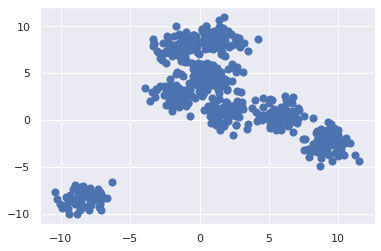

In [2]:
# Set the number of clusters that the algorithm should ideally find
centerSeed = 8

# Making the "blobs"
X, y_true = make_blobs(n_samples=600, centers=centerSeed,
                       cluster_std=0.9, random_state=0)
# Plot the data
plt.scatter(X[:, 0], X[:, 1], s=50);




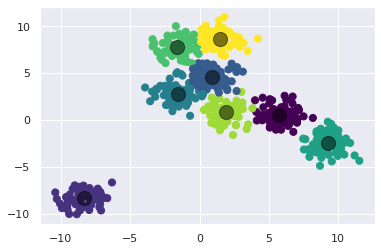

In [3]:
# Applying the clustering to 

kmeans = KMeans(n_clusters=centerSeed)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Plotting the data again, but coloured by the clusters, and the centroids highlighted by the black point
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


## 2. Using Information Criteria to inform parameter choices 

Assessing if identified structures give us "useful" information is very important, and we can do this applying statistical tools.




In [4]:
repeats = 5 # Remember there is stochasticity involved, so de do 10 repeats to collect some error estimates.
kClusters = 25 # Going up to a high number as out "guess" takes time, but it can be worth it!
data = X

criteriaAIC_BIC = np.zeros((repeats,2,kClusters))
for rep in np.arange(0,repeats):
    for nr in np.arange(1,kClusters):
        n_clusters=nr
        X=data
        model=mixture.GaussianMixture(n_components=n_clusters, init_params='kmeans')
        model.fit(X)
        criteriaAIC_BIC[rep,0,nr]=model.aic(X)
        criteriaAIC_BIC[rep,1,nr]=model.bic(X)

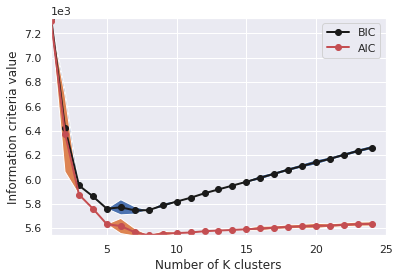

In [5]:
meanAIC = criteriaAIC_BIC[:, 0, 0:kClusters].mean(axis = 0)
stdAIC = criteriaAIC_BIC[:, 0, 0:kClusters].std(axis = 0)

meanBIC = criteriaAIC_BIC[:, 1, 0:kClusters].mean(axis = 0)
stdBIC = criteriaAIC_BIC[:, 1, 0:kClusters].std(axis = 0)

plt.plot(np.arange(0, kClusters),meanBIC, '-ok', label='BIC', linewidth=2)
plt.fill_between(np.arange(0, kClusters), meanBIC-2*stdBIC, meanBIC+2*stdBIC)

plt.plot(np.arange(0, kClusters),meanAIC, '-or', label='AIC', linewidth=2)
plt.fill_between(np.arange(0, kClusters), meanAIC-2*stdAIC, meanAIC+2*stdAIC)


plt.ylim(np.min(meanAIC[5:]), np.max(meanBIC))
plt.xlabel('Number of K clusters')
plt.ylabel('Information criteria value')
plt.legend()
plt.xlim(1,kClusters)
#plt.ylim(5.60e3, 5.78e3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('informationCriteriaAsymptoting_wError.png', format='png', dpi=500, bbox_inches='tight')  

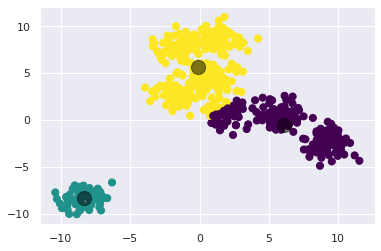

In [6]:
### Replace with your guess!
clusterGuess=3

kmeans = KMeans(n_clusters=clusterGuess)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


We now make synthetic data that is not round but elongated (anisotropic). The difference in the structure of the data will be used to reveal the shortcomings of a method that operates under the assumptions of k-means.

Different methods operate under different assumptions. We explore the Density-based spatial clustering of applications with noise (DBSCAN). This algorithm uses the distance between the datapoints, and a set minimum of points needed to be "significant".

Text(0.5, 1.0, 'Anisotropicly Distributed Data')

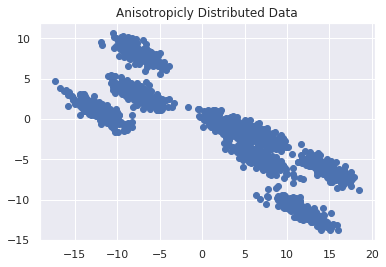

In [7]:
centerSeed = 8
n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state, centers=centerSeed)


#### Anisotropicly distributed data ####
transformation = [[1.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], cmap='viridis')
plt.title("Anisotropicly Distributed Data")



### Using k-means on structures that are not round

Here we demonstrate what k-means does when we explore data that do *not* conform with our assumption.

The data is somewhat randomly 'chopped', and fails to find the underlying structures.

Text(0.5, 1.0, 'Anisotropicly Distributed Data: K-means')

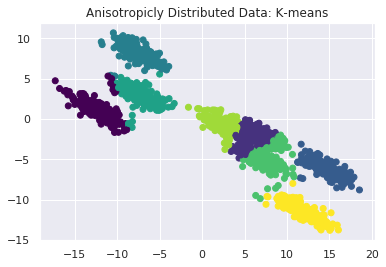

In [8]:
cluster_guess=8

y_pred = KMeans(n_clusters=cluster_guess, random_state=random_state).fit_predict(X_aniso)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred, cmap='viridis')
plt.title("Anisotropicly Distributed Data: K-means")


The number of clusters DBSCAN found was:  8


Text(0.5, 1.0, 'Anisotropicly Distributed Data: DBSCAN')

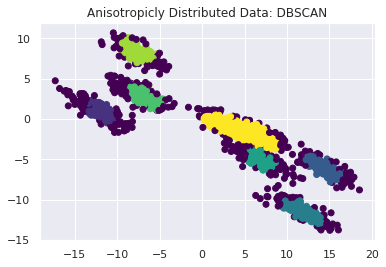

In [10]:

EPS=0.5
MIN_SAMP=12


#Anisotropicly distributed data
transformation = [[1.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = DBSCAN(eps=EPS, min_samples=MIN_SAMP).fit_predict(X_aniso)

print('The number of clusters DBSCAN found was: ', len(np.unique(y_pred)))
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred, cmap='viridis')
plt.title("Anisotropicly Distributed Data: DBSCAN")

## Bonus material

We continue to explore visually what happens when the structures we are looking for can and cannot be isolated using the clustering algorithms we have been exploring. 

Automatically created module for IPython interactive environment


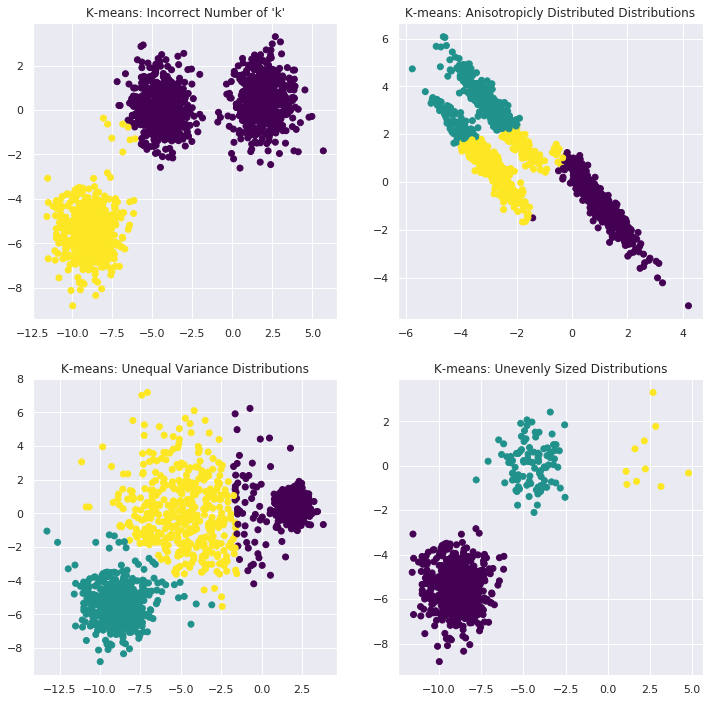

In [32]:
print(__doc__)

# Modofied by <maikejulie@gmail.com> from Phil Roth <mr.phil.roth@gmail.com>
# License: BSD 3 clause

plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

#### Incorrect number of clusters ####
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis')
plt.title("K-means: Incorrect Number of 'k'")

#### Anisotropicly distributed data ####
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred, cmap='viridis')
plt.title("K-means: Anisotropicly Distributed Distributions")

#### Different variance #####
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred, cmap='viridis')
plt.title("K-means: Unequal Variance Distributions")

##### Unevenly sized blobs ####
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3,
                random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred, cmap='viridis')
plt.title("K-means: Unevenly Sized Distributions")

plt.show()

Automatically created module for IPython interactive environment


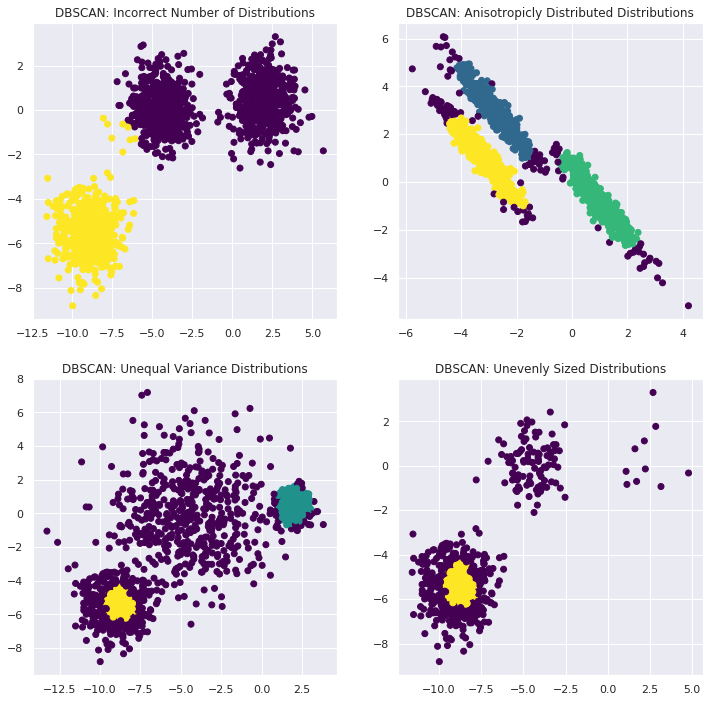

In [30]:
print(__doc__)

EPS=0.3
MIN_SAMP=20

plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis')
plt.title("DBSCAN: Incorrect Number of Distributions")

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = DBSCAN(eps=EPS, min_samples=MIN_SAMP).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred, cmap='viridis')
plt.title("DBSCAN: Anisotropicly Distributed Distributions")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = DBSCAN(eps=EPS, min_samples=MIN_SAMP).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred, cmap='viridis')
plt.title("DBSCAN: Unequal Variance Distributions")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = DBSCAN(eps=EPS, min_samples=MIN_SAMP).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred, cmap='viridis')
plt.title("DBSCAN: Unevenly Sized Distributions")

plt.show()

This tutorial is by Maike Sonnewald (github: maikejulie, maikejulie@gmail.com), drawing from Randy Olson (github: rhiever), and Phil Roth <mr.phil.roth@gmail.com>
(License: BSD 3 clause)